In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports
Firstly, all necessary libraries are imported.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import struct
import warnings
#warnings.filterwarnings("ignore")
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Load Images
Fish images are loaded. There are 9 kinds of fish with each having 1000 different samples. Each sample is in the directory labeled with the name of that fish kind. Samples are already rotated and this will decrease overfitting. Ground truth images are used both for simplification and to avoid color memorization which could cause overfitting. Therefore, the model will be trained with shapes of the fish.

In [2]:
main_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
fish_kinds = ["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet",
              "Red Sea Bream", "Sea Bass", "Shrimp", "Striped Red Mullet", "Trout"]

X = []
y = []

for fish_kind in fish_kinds:
    fish_folder = os.path.join(main_path, fish_kind, fish_kind+" GT")
    for img_name in os.listdir(fish_folder):
        img = Image.open(os.path.join(fish_folder, img_name))
        img_array = np.array(img)
        X.append(img_array)
        y.append(fish_kind)
        
X = np.array(X)
y = np.array(y)

It can be observed that we have 9000 total samples (9 kinds and 1000 samples for each) and each image is 445x590 pixels.

In [3]:
print(X.shape)
print(y.shape)

(9000, 445, 590)
(9000,)


# Train-Test-Validation Split
Data is split as train, test and validation. Their respective percentages are 70%, 15% and 15%. Most of the data is reserved for training to increase the model's learning capacity.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(6300, 445, 590)
(6300,)
(1350, 445, 590)
(1350,)
(1350, 445, 590)
(1350,)


Images below show 15 random samples from the test data with their labels.

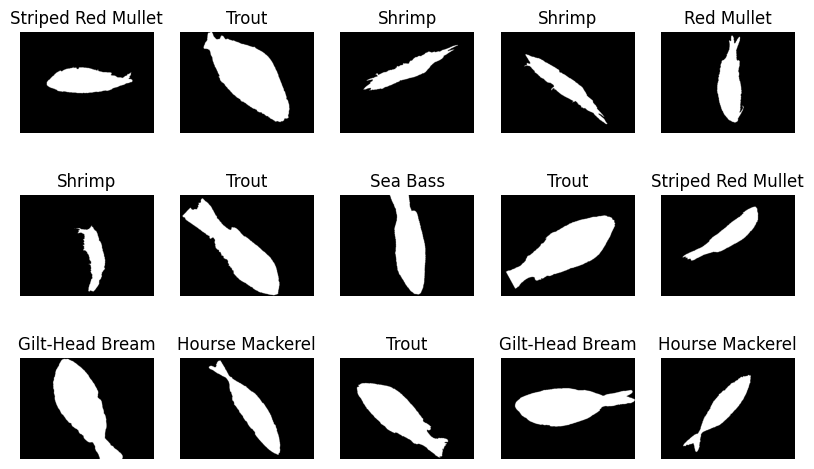

In [5]:
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

# Flattening & Normalization
2D pixel data is flattened to 1D and normalized to the values between 0 and 1 for easier computation.

In [6]:
X_train = X_train.reshape((X_train.shape[0], 445 * 590)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 445 * 590)).astype('float32') / 255
X_val = X_val.reshape((X_val.shape[0], 445 * 590)).astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(6300, 262550)
(1350, 262550)
(1350, 262550)


# One-Hot Encoding
One-hot encoding is done. For that each label is first encoded to an integer value, then those values are used for one-hot encoding since having integer labels is required for one-hot encoding.

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(fish_kinds)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

y_train = tf.keras.utils.to_categorical(y_train, 9)
y_val = tf.keras.utils.to_categorical(y_val, 9)
y_test = tf.keras.utils.to_categorical(y_test, 9)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.]])

# Model Creation

In [8]:
model = tf.keras.models.Sequential()

# Input Layer
An input layer with 1024 neurons is added. It's activation function is relu to get rid of negative values. 25% of the neurons are randomly shut down to decrease overfitting.

In [9]:
model.add(tf.keras.layers.Input(shape=(445 * 590,)))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Hidden Layers
Similarly, hidden layers are added. Each layer has half as many neurons as the previous layer.

In [10]:
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Output Layer
Output layer is added. There are 9 nerurons such that there is one neuron for each label. Activation function is chosen as softmax for making classifications.

In [11]:
model.add(tf.keras.layers.Dense(9, activation='softmax'))

# Compiling the Model
The model is compiled with its optimizer, loss function and metrics. Accuracy is chosen as a metric because it is desired as high as possible.

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Fitting
Model fitting is done by using train and validation data. Epoch is chosen as 10 and batch size is chosen as 126 so that each batch has the same amount of samples while batch size being close to a power of 2.

In [13]:
results = model.fit(X_train, y_train, epochs=10, batch_size=126, validation_data=(X_val, y_val))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.1866 - loss: 2.0448 - val_accuracy: 0.4281 - val_loss: 1.4775
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.3966 - loss: 1.5330 - val_accuracy: 0.5237 - val_loss: 1.2367
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.4756 - loss: 1.3106 - val_accuracy: 0.5489 - val_loss: 1.1605
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.5538 - loss: 1.1612 - val_accuracy: 0.5941 - val_loss: 1.0391
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.6065 - loss: 1.0344 - val_accuracy: 0.6030 - val_loss: 1.0243
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.6384 - loss: 0.9644 - val_accuracy: 0.6281 - val_loss: 0.9464
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.6696 - loss: 0.8720 - val_accuracy: 0.6593 - val_loss: 0.9156
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.7057 - loss: 0.8133 - val_accuracy: 0.6659 - v

Graphs below show the change in loss and accuracy between each epoch.

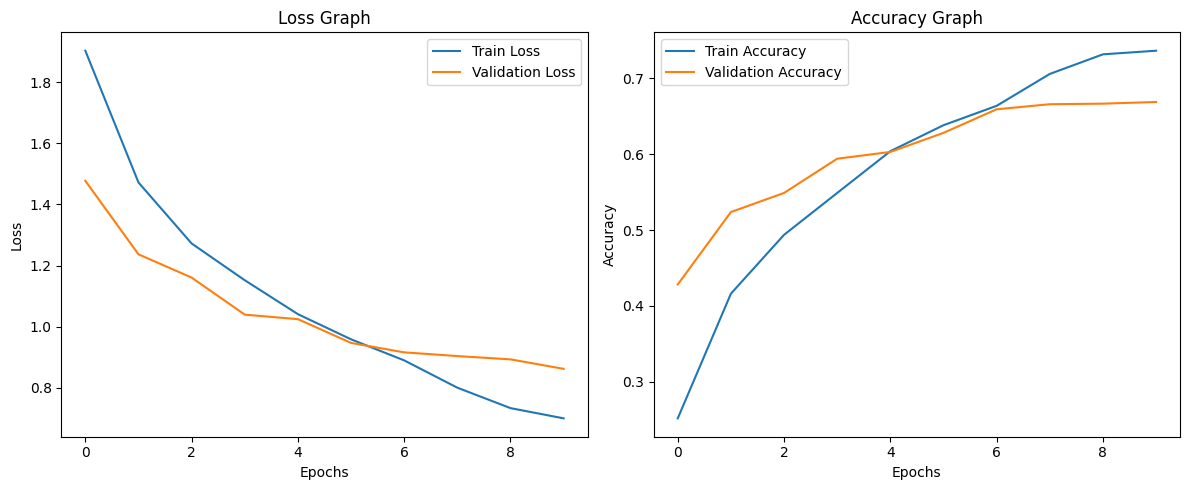

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction
Using the model trained, labels of the test data are predicted.

In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step


# Conclusion
In the end, we get an accuracy of 67.70% which is similar to the validation accuracy of 66.89%. Train accuracy is a bit higher than both of them with 74.38%. There may be little overfitting and epoch could be 6 or 7 for minimizing that. Validation accuracy doesn't seem to rise up that much anyway after epoch 7.

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.8671654462814331
Test Accuracy: 0.6770370602607727
